## Importing Relevant Libraries

#### General

In [1]:
import pandas as pd
import numpy as np

#### For clustering

In [2]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

#### For principal component analysis

In [3]:
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.decomposition import PCA

#### For plotting

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================
# 1. Reading In The Data
# =============================================================

### Read in data from PVL-Delta model

In [5]:
df_pvl_delta = pd.read_csv("./data/parameter_igt_pvl_delta.csv")

#### Inspect the data

In [6]:
df_pvl_delta.head()

group  SubID        LR  Outcome_Sens  Response_cons  Loss_Aver
0  young      1  0.159011      0.487522       0.686815   0.954498
1  young      2  0.064666      0.511008       1.391790   0.295529
2  young      3  0.113089      0.465141       0.918734   0.533232
3  young      4  0.089273      0.500391       0.703737   0.869859
4  young      5  0.233898      0.488053       0.897867   0.511095

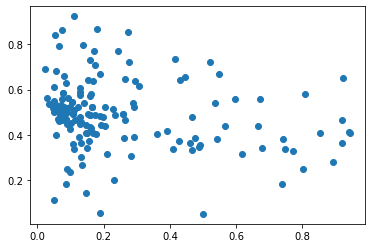

In [7]:
plt.scatter(df_pvl_delta["LR"], df_pvl_delta["Outcome_Sens"])

#### Processing
'SubID' column can be dropped as it is not used for analysis.

In [8]:
df_pvl_delta.drop(columns=['SubID'], inplace=True)

In [9]:
df_pvl_delta.head()

group        LR  Outcome_Sens  Response_cons  Loss_Aver
0  young  0.159011      0.487522       0.686815   0.954498
1  young  0.064666      0.511008       1.391790   0.295529
2  young  0.113089      0.465141       0.918734   0.533232
3  young  0.089273      0.500391       0.703737   0.869859
4  young  0.233898      0.488053       0.897867   0.511095

### Read in data from the ORL model

In [10]:
df_orl = pd.read_csv("./data/parameter_igt_orl.csv")

#### Inspect the data

In [11]:
df_orl.head()

subjID        A+        A-         K     BetaF     BetaP     A+-A-
0    old  0.324444  0.068862  1.502130  2.523191 -5.547480  0.255581
1    old  0.885744  0.120145  0.012591  3.193244 -9.159800  0.765598
2    old  0.318205  0.078128  1.927309  0.615708  9.272336  0.240077
3    old  0.728192  0.106737  0.388407  2.595746 -2.239555  0.621455
4    old  0.356229  0.091987  1.810674  0.508605  9.825699  0.264241

#### Processing
'subjID' column in input file is actually the 'group' column based on its contents. Thus, rename the column as so.

In [12]:
df_orl.rename(columns={'subjID':'group'}, inplace=True)
df_orl.head()

group        A+        A-         K     BetaF     BetaP     A+-A-
0   old  0.324444  0.068862  1.502130  2.523191 -5.547480  0.255581
1   old  0.885744  0.120145  0.012591  3.193244 -9.159800  0.765598
2   old  0.318205  0.078128  1.927309  0.615708  9.272336  0.240077
3   old  0.728192  0.106737  0.388407  2.595746 -2.239555  0.621455
4   old  0.356229  0.091987  1.810674  0.508605  9.825699  0.264241

### Read in data from the VPP model

In [13]:
df_vpp = pd.read_csv("./data/parameters_igt_vpp.csv")

#### Inspect the data

In [14]:
df_vpp.head()

group  SubID        LR  Out_Sens  Res_Cons  Loss_Aver  Gain_Impa  \
0  young      1  0.038441  0.630402  1.207295   1.050323  -0.535035   
1  young      2  0.045673  0.630331  1.628191   0.205205  -0.133367   
2  young      3  0.045468  0.602974  1.395572   0.383055  -0.344822   
3  young      4  0.035789  0.635677  1.067831   0.823790  -0.229192   
4  young      5  0.060655  0.636276  1.802964   0.329246  -0.616020   

   Loss_Impa  Deca_Rate  RL_weight  
0  -1.913099   0.669323   0.660446  
1  -1.423580   0.427207   0.719352  
2  -1.719826   0.493249   0.688723  
3  -1.484455   0.625835   0.675971  
4  -2.561017   0.439912   0.655563

#### Processing
'SubID' column is dropped as before as it is not used for analysis.

In [15]:
df_vpp.drop(columns=['SubID'], inplace=True)
df_vpp.head()

group        LR  Out_Sens  Res_Cons  Loss_Aver  Gain_Impa  Loss_Impa  \
0  young  0.038441  0.630402  1.207295   1.050323  -0.535035  -1.913099   
1  young  0.045673  0.630331  1.628191   0.205205  -0.133367  -1.423580   
2  young  0.045468  0.602974  1.395572   0.383055  -0.344822  -1.719826   
3  young  0.035789  0.635677  1.067831   0.823790  -0.229192  -1.484455   
4  young  0.060655  0.636276  1.802964   0.329246  -0.616020  -2.561017   

   Deca_Rate  RL_weight  
0   0.669323   0.660446  
1   0.427207   0.719352  
2   0.493249   0.688723  
3   0.625835   0.675971  
4   0.439912   0.655563

# =============================================================
# 2. Scale the Data
# =============================================================

#### Choose which data source to use

In the paper, Lili concludes that the VPP model was the best-fitting model in terms of short-term prediction performance for the IGT task, as measured by one-step-ahead leave-one-out information criterion (LOOIC). Therefore, we will begin by analysing this dataset.

In [16]:
chosen_df = df_vpp

* The *'group'* column will not be used as a feature for the clustering analysis, so we will exclude this from the processing for now.

In [17]:
train_df = chosen_df.iloc[:, 1:]

We can describe the data in this dataframe and look at the ranges of the variables and their distributions

In [18]:
train_df.describe()

LR    Out_Sens    Res_Cons   Loss_Aver   Gain_Impa   Loss_Impa  \
count  153.000000  153.000000  153.000000  153.000000  153.000000  153.000000   
mean     0.070824    0.560575    1.329323    0.952138    0.460940   -0.720379   
std      0.064683    0.111139    0.198041    0.580621    1.185591    1.102656   
min      0.027454    0.352471    0.879707    0.193857   -2.977630   -2.912838   
25%      0.038294    0.448811    1.202790    0.528927   -0.287230   -1.634716   
50%      0.050247    0.590334    1.316736    0.760613    0.593115   -0.779120   
75%      0.078495    0.646090    1.428836    1.292569    1.419412    0.137599   
max      0.617431    0.818137    1.938694    2.698527    2.559126    1.583109   

        Deca_Rate   RL_weight  
count  153.000000  153.000000  
mean     0.406367    0.622995  
std      0.187483    0.066657  
min      0.042780    0.452978  
25%      0.256420    0.569390  
50%      0.439912    0.640917  
75%      0.565139    0.675971  
max      0.858421    0.744017

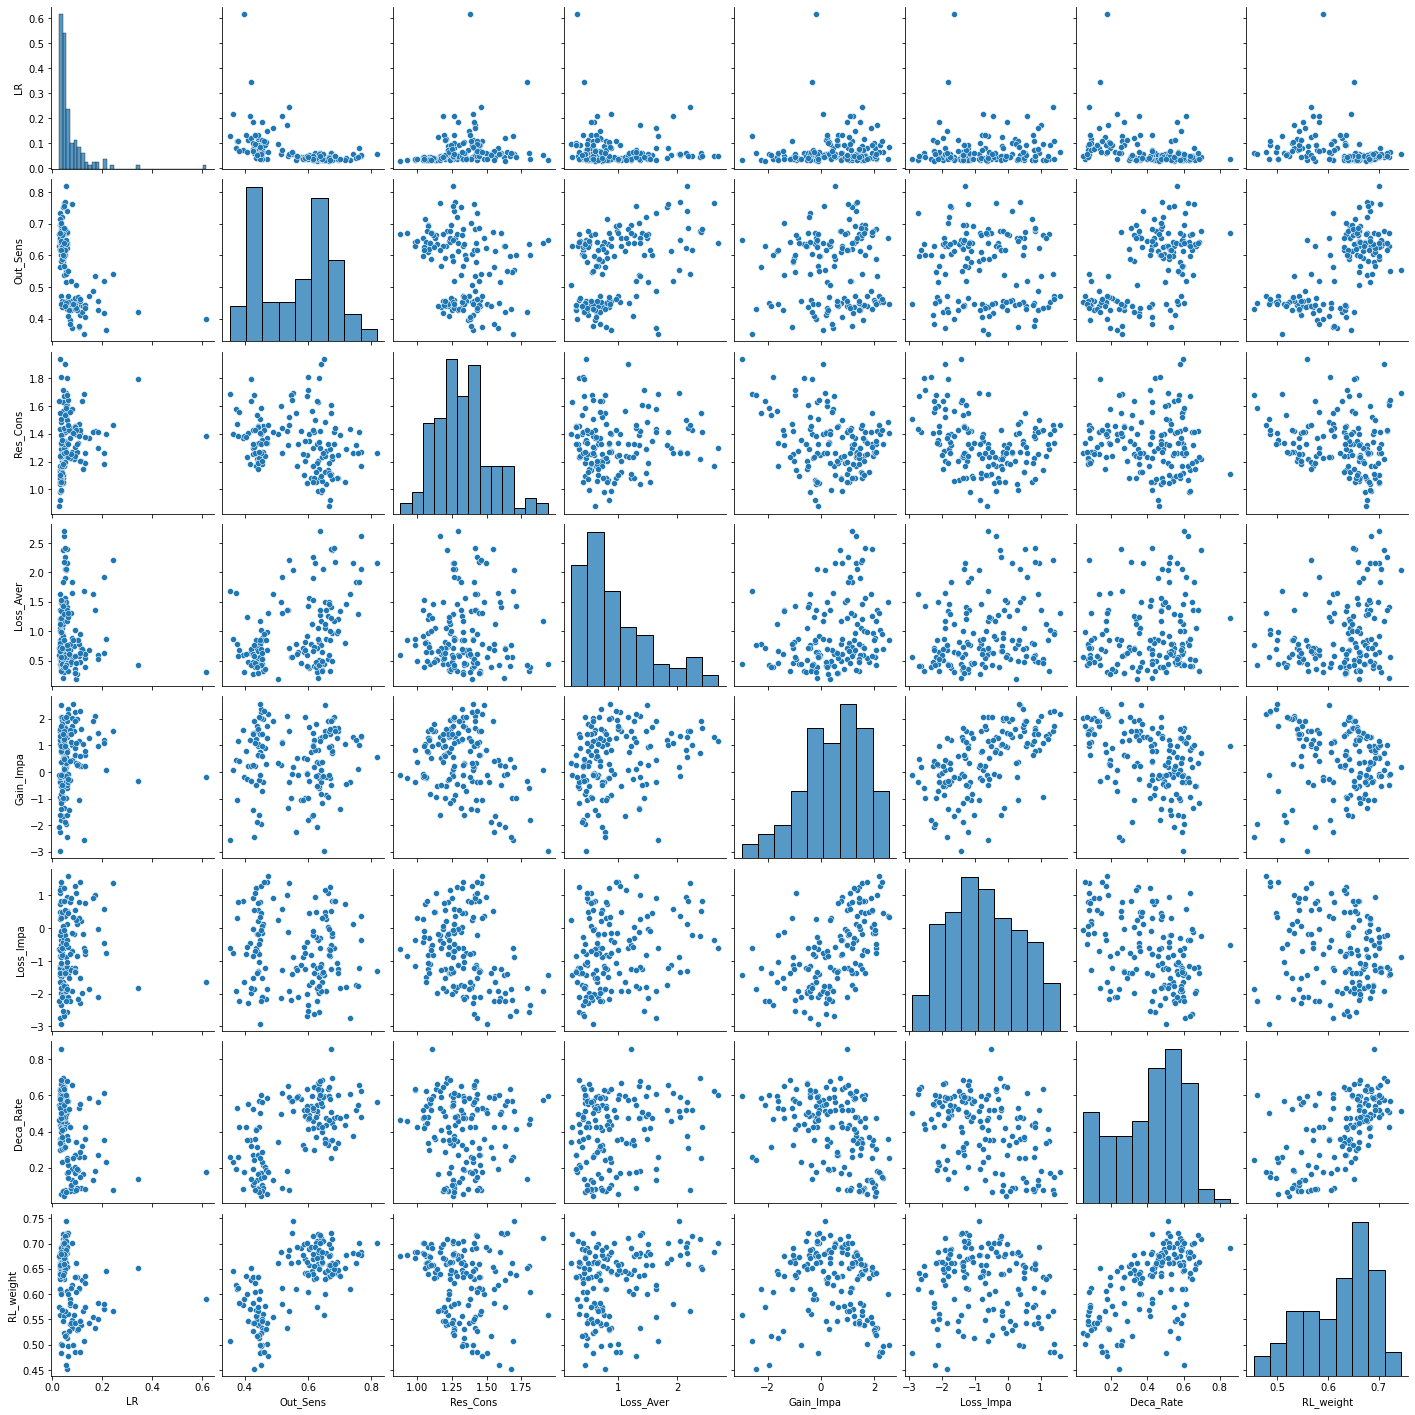

In [19]:
#Visualising the distributions of the different variables
sns.pairplot(train_df)

From the pair plot above, we can clearly see that many of the variables have either positively or negatively skewed distributions. There also appears to be many outliers in each distribution and the different parameters don't share a common scale.

To remedy this and also to ensure sound clustering analysis, we need to **scale** the dataset.

#### Scaling the features

In [20]:
# Standardising the data
standardised_train_array = StandardScaler().fit_transform(train_df)

# Normalizing the data - NEEDS CHANGING
normalised_nd_standardised_train_array = normalize(standardised_train_array, axis=0)
#normalised_nd_standardised_train_array = MinMaxScaler(standardised_train_array)

# Converting the scaled array back to a DataFrame
scaled_train_df = pd.DataFrame(normalised_nd_standardised_train_array, columns=train_df.columns)

In [21]:
scaled_train_df.describe()

LR      Out_Sens      Res_Cons     Loss_Aver   Gain_Impa  \
count  1.530000e+02  1.530000e+02  1.530000e+02  1.530000e+02  153.000000   
mean  -2.902544e-18  1.161018e-17  2.031781e-17  1.451272e-18    0.000000   
std    8.111071e-02  8.111071e-02  8.111071e-02  8.111071e-02    0.081111   
min   -5.438584e-02 -1.518770e-01 -1.841472e-01 -1.059293e-01   -0.235245   
25%   -4.079214e-02 -8.156703e-02 -5.182350e-02 -5.912117e-02   -0.051185   
50%   -2.580297e-02  2.171851e-02 -5.155164e-03 -2.675543e-02    0.009043   
75%    9.618559e-03  6.240928e-02  4.075695e-02  4.755704e-02    0.065573   
max    6.854293e-01  1.879718e-01  2.495777e-01  2.439647e-01    0.143545   

          Loss_Impa     Deca_Rate     RL_weight  
count  1.530000e+02  1.530000e+02  1.530000e+02  
mean   2.902544e-18 -1.161018e-17 -2.612289e-17  
std    8.111071e-02  8.111071e-02  8.111071e-02  
min   -1.612760e-01 -1.572984e-01 -2.068814e-01  
25%   -6.725810e-02 -6.487139e-02 -6.522806e-02  
50%   -4.320979e-03  1.451265e-02  2.180811e-02  
75%    6.311234e-02  6.868974e-02  6.446273e-02  
max    1.694432e-01  1.955719e-01  1.472632e-01

#### Add the group feature back in

Since the data is now fully processed and ready for clustering, we can add the *'group'* column back in as it will be needed later on.

In [22]:
scaled_full_df = pd.concat([chosen_df.iloc[:, 0], scaled_train_df], axis=1)

In [23]:
scaled_full_df.head()

group        LR  Out_Sens  Res_Cons  Loss_Aver  Gain_Impa  Loss_Impa  \
0  young -0.040608  0.050960 -0.049978   0.013716  -0.068138  -0.087736   
1  young -0.031540  0.050908  0.122406  -0.104344  -0.040659  -0.051727   
2  young -0.031797  0.030943  0.027133  -0.079499  -0.055125  -0.073519   
3  young -0.043933  0.054810 -0.107098  -0.017930  -0.047214  -0.056205   
4  young -0.012752  0.055247  0.193987  -0.087016  -0.073679  -0.135396   

   Deca_Rate  RL_weight  
0   0.113763   0.045572  
1   0.009016   0.117250  
2   0.037588   0.079980  
3   0.094949   0.064463  
4   0.014513   0.039631

# =============================================================
# 3. Consideration of Clustering Algorithms & Number of clusters
# =============================================================

There are a number of clustering algorithms which we could implement. Below, we try the *KMeans* and *Spectral Clustering* algorithms and analyse how these perform on the data in question. 

To determine which algorithm is more appropriate to the dataset, we will measure their performance using the *Silhouette Coefficient*. The Silhouette Coefficient of a data point quantifies how similar a data point is to its own cluster compared to other clusters. We will use the mean Silhouette Coefficient across all data points to compare the performace of algorithms.

The **Silhouette Coefficient** for a particular data point is calculated by the below formula:

$$s = \frac{b - a}{max(a, b)}$$

Where:

 - **a** is the mean distance between a data point and all other points in the same cluster. (the mean intra-cluster distance)
 - **b** is the mean distance between a data point and all other points in the *next nearest cluster*. (the mean nearest-cluster distance)

The Silhouette score can assume values between -1 and 1. Scores closer to -1 indicate incorrect clustering whereas those nearer to +1 indicate highly dense clustering. Scores around zero are indicative of overlapping clusters. Therefore, a good indicator of what clustering algorithm to choose would be the one whose mean Silhouette Coefficient is nearest to 1.


Peter J. Rousseeuw (1987). “Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis”. Computational and Applied Mathematics 20: 53–65. doi:10.1016/0377-0427(87)90125-7.

#### Choose the number of clusters to test these algorithms on

In [24]:
num_clusters_to_iter = range(2, 11)

In [ ]:
def get_silhouette_scores(scaled_train_df, model_function, num_clusters_to_itr):
    
    # Initialise empty list for the Silhouette Scores for KMeans model
    s_scores = []

    # Running algorithm and calculating Silhouette Score
    for k in num_clusters_to_iter:

        # Building the clustering model 
        model = model_function(n_clusters = k, random_state = 0)
        
        # Training the model and storing the predicted cluster labels
        labels = model.fit_predict(scaled_train_df)

        # Evaluating the performance and adding score to list
        s_scores.append(silhouette_score(scaled_train_df, labels))

    return s_scores

## Silhouette Scores for the KMeans Algorithm

Below the KMeans algorithm is executed with various different numbers of clusters (from 2 clusters to 10). The mean Silhouette Coefficient (or more simply, the *Silhouette Score*) for the clusters produced is calculated for each execution of the algorithm. These scores are plotted below.

#### Use K-Means to calculate the Silhouette Score for 2-10 clusters

In [49]:
# Initialise empty list for the Silhouette Scores for KMeans model
s_scores_km = []

# Running algorithm and calculating Silhouette Score
for k in num_clusters_to_iter:
    
    # Building the clustering model 
    km_model = KMeans(n_clusters = k, random_state = 0)

    # Training the model and storing the predicted cluster labels
    km_labels = km_model.fit_predict(scaled_train_df)
    
    # Evaluating the performance and adding score to list
    s_scores_km.append(silhouette_score(scaled_train_df, km_labels))

#### Analyse these scores and output & plot the score

The maximum Silhouette Score was 0.2951295885819213
This score is achieved by running 2 clusters


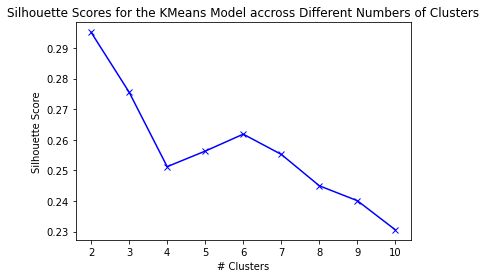

# Clusters             2         3         4       5         6         7   \
Silhouette Score  0.29513  0.275548  0.251219  0.2563  0.261833  0.255223   

# Clusters              8         9         10  
Silhouette Score  0.244964  0.240095  0.230552

In [50]:
# Analyse these results to see the optimal cluster number
max_silhouette_score_km = max(s_scores_km)
index_max_score_km = s_scores_km.index(max_silhouette_score_km)

print("The maximum Silhouette Score was", max_silhouette_score_km)
print("This score is achieved by running", num_clusters_to_iter[index_max_score_km], "clusters")

# plot the silhoutte scores against the cluster numbers
plt.plot(num_clusters_to_iter, s_scores_km, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for the KMeans Model accross Different Numbers of Clusters')
plt.show()

# Output a table of the score for each cluster
cluster_nd_score_km_df = pd.DataFrame(s_scores_km, index=num_clusters_to_iter).rename(columns={0: "Silhouette Score"})
cluster_nd_score_km_df.index.name = "# Clusters"
cluster_nd_score_km_df.T

## Silhouette Scores for Spectral Clustering Algorithm

In order to explore more options for clustering, we are going to test the performance of two different implementations of the Spectral Clustering algorithm. One implementation constructs the *affinity matrix* using a radial basis function (RBF) kernel (aka Gaussian kernel) while the other constructs this matrix by computing a graph of nearest neighbors.

### Spectral Clustering with *affinity='rbf'*

#### Use Spectral Clustering to calculate the Silhouette Score for 2-10 clusters

In [51]:
# Initialise empty list for the Silhouette Scores for Spectral 'rbf' model
s_scores_rbf = []

# Running algorithm and calculating Silhouette Score
for k in num_clusters_to_iter:
    
    # Building the clustering model 
    spectral_model_rbf = SpectralClustering(n_clusters = k, affinity ='rbf', random_state=0)

    # Training the model and storing the predicted cluster labels
    labels_rbf = spectral_model_rbf.fit_predict(scaled_train_df)
    
    # Adding Silhouette Score to list
    s_scores_rbf.append(silhouette_score(scaled_train_df, labels_rbf))

#### Analyse these scores and output & plot the score

The maximum Silhouette Score was 0.2951295885819213
This score is achieved by running 2 clusters


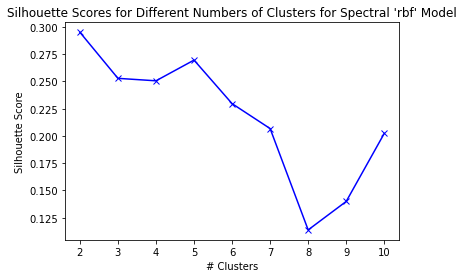

# Clusters             2         3        4         5         6         7   \
Silhouette Score  0.29513  0.252844  0.25059  0.269575  0.229649  0.206779   

# Clusters              8         9         10  
Silhouette Score  0.113822  0.139949  0.202321

In [52]:
# Analyse these results to see the optimal cluster number
max_silhouette_score_rbf = max(s_scores_rbf)
index_max_score_rbf = s_scores_rbf.index(max_silhouette_score_rbf)

print("The maximum Silhouette Score was", max_silhouette_score_rbf)
print("This score is achieved by running", num_clusters_to_iter[index_max_score_rbf], "clusters")

# plot the silhoutte scores against the cluster numbers
plt.plot(num_clusters_to_iter, s_scores_rbf, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters for Spectral \'rbf\' Model')
plt.show()

# Output a table of the score for each cluster
cluster_nd_score_rbf_df = pd.DataFrame(s_scores_rbf, index=num_clusters_to_iter).rename(columns={0: "Silhouette Score"})
cluster_nd_score_rbf_df.index.name = "# Clusters"
cluster_nd_score_rbf_df.T

### Spectral Clustering with *affinity='nearest_neighbors'*

#### Use Spectral Clustering to calculate the Silhouette Score for 2-10 clusters

In [54]:
# Initialise empty list for the Silhouette Scores for Spectral 'nearest_neighbors' model
s_scores_nn = []

# Running algo and storing Silhouette Score for each no. of clusters
for k in num_clusters_to_iter:
    
    # Building the clustering model
    spectral_model_nn = SpectralClustering(n_clusters = k, affinity ='nearest_neighbors', random_state = 0)

    # Training the model and storing the predicted cluster labels
    labels_nn = spectral_model_nn.fit_predict(scaled_train_df)
    
    # Evaluating the performance 
    s_scores_nn.append(silhouette_score(scaled_train_df, labels_nn))

#### Analyse these scores and output & plot the score

The maximum Silhouette Score was 0.2951295885819213
This score is achieved by running 2 clusters


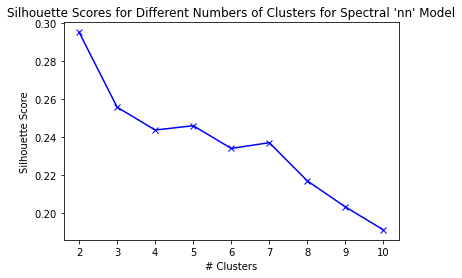

# Clusters             2         3         4         5         6         7   \
Silhouette Score  0.29513  0.255765  0.243764  0.246033  0.234108  0.237116   

# Clusters             8         9         10  
Silhouette Score  0.21703  0.203375  0.191292

In [55]:
# Analyse these results to see the optimal cluster number
max_silhouette_score_nn = max(s_scores_nn)
index_max_score_nn = s_scores_nn.index(max_silhouette_score_nn)

print("The maximum Silhouette Score was", max_silhouette_score_nn)
print("This score is achieved by running", num_clusters_to_iter[index_max_score_nn], "clusters")

# plot the silhoutte scores against the cluster numbers
plt.plot(num_clusters_to_iter, s_scores_nn, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters for Spectral \'nn\' Model')
plt.show()

# Output a table of the score for each cluster
cluster_nd_score_nn_df = pd.DataFrame(s_scores_nn, index=num_clusters_to_iter).rename(columns={0: "Silhouette Score"})
cluster_nd_score_nn_df.index.name = "# Clusters"
cluster_nd_score_nn_df.T

As we can see from the above results, running these clustering algorithms on this data using **two clusters** produces the best Silhouette Scores for all three algorithms.

One reason we can see why this might be the case is that the sample of data subjects can be segmented into two groups as we saw at the start; *'young'* and *'old'* and these two clusters could just be encapsulating these two groups.
To test this, we will attempt to visualise these clusters.

From the above ouputs, we can determine that Kmeans and Spectral Clustering using the nearest_neighbour affinity get the same sillhouette score for two clusters, while Spectral clustering using the rbf affinity lags a little bit behind on its sillhouette score for two clusters.

As a result, we will test our hypothesis using the Spectral Clustering algorithm to create two clusters, with 'nearest neighbour' being used to construct the affinity matrix.

#### Choose Number of Clusters to use

In [56]:
num_clusters = 2

# =============================================================
# 4. Cluster the data
# =============================================================

#### Build the 'rbf' spectral clustering model with these 2 clusters

In [57]:
spectral_model = SpectralClustering(n_clusters=num_clusters, affinity='rbf')

#### Training the model and storing predicted cluster labels

In [58]:
cluster_labels_array = spectral_model.fit_predict(scaled_train_df)

#### Turn this array to a dataframe so it can be concatonated with the rest of the data

In [70]:
cluster_labels_df = pd.DataFrame(cluster_labels_array).rename(columns={0: "Cluster"})

In [71]:
cluster_labels_df.head()

Cluster
0        0
1        0
2        0
3        0
4        0

#### Add a new column to the original data with the cluster each row is in

In [61]:
full_df_nd_cluster = pd.concat([chosen_df, cluster_labels_df], axis=1)

In [62]:
full_df_nd_cluster.head()

group        LR  Out_Sens  Res_Cons  Loss_Aver  Gain_Impa  Loss_Impa  \
0  young  0.038441  0.630402  1.207295   1.050323  -0.535035  -1.913099   
1  young  0.045673  0.630331  1.628191   0.205205  -0.133367  -1.423580   
2  young  0.045468  0.602974  1.395572   0.383055  -0.344822  -1.719826   
3  young  0.035789  0.635677  1.067831   0.823790  -0.229192  -1.484455   
4  young  0.060655  0.636276  1.802964   0.329246  -0.616020  -2.561017   

   Deca_Rate  RL_weight  Cluster  
0   0.669323   0.660446        0  
1   0.427207   0.719352        0  
2   0.493249   0.688723        0  
3   0.625835   0.675971        0  
4   0.439912   0.655563        0

Now that we have clustered this data based on the parameters, we want to verify our hypothesis that these 2 clusters will just contain the 'Young' and 'Old' groups exclusively.

We want to analyse these clusters to see how the 'Old' and 'Young' fall into these clusters and test this.

# =========================================================================
# 5. Analyse the Clusters
# =============================================================

#### Create a dataframe showing how many people fell into each cluster

In [63]:
all_cluster_df = pd.DataFrame(full_df_nd_cluster[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "All"})

#### Change 'young' to 1 and 'old' to np.nan

In [64]:
temp_full_df_nd_cluster = full_df_nd_cluster.copy()

In [65]:
temp_full_df_nd_cluster["group"] = full_df_nd_cluster["group"].replace('old', np.nan).replace('young', 1)

#### Create a dataframe showing how many young people fell into each cluster

In [66]:
young_cluster_df = pd.DataFrame(temp_full_df_nd_cluster[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "Young"})

#### Create a dataframe showing how many old people fell into each cluster

In [67]:
old_cluster_df = pd.DataFrame(temp_full_df_nd_cluster["group"].isnull().groupby(full_df_nd_cluster["Cluster"]).sum().astype(int)).rename(columns={"group": "Old"})

#### Output how many 'young' and 'old' people fell into each cluster

In [68]:
pd.merge(all_cluster_df, pd.merge(young_cluster_df, old_cluster_df, how="inner", on="Cluster"), how="inner", on="Cluster")

All  Young  Old
Cluster                 
0         90     90    0
1         63      0   63

As you can see from the above table, our hypthesis was correct and the algorithm clustered the individuals into their respective groups of young and old.

While this test did not provide us with any more information than we already had, we felt it was vital to not make any assumptions but to verify everything before we act.
So even though from the analysis using the 'Silhouette Score' we identified that two clusters maximised this score, as we hypothesised this is because of how distinct the two groups of individuals are when it comes to decision making. As a result, we have not gained much aditional information about the data by having 2 clusters so we must experiment with a different number.

# =============================================================
# 6. Consideration of Clustering Algorithms & Number of clusters (2)
# =============================================================

So we have experimented using two clusters and have decided that this does not provide us with enough aditional information to satisfy our analysis.


In [82]:
def print_max_silhouette_score_and_its_cluster_number(list_of_silhouette_scores, list_of_cluster_numbers):
    
    max_silhouette_score = max(list_of_silhouette_scores)
    index_max_score = list_of_silhouette_scores.index(max_silhouette_score)

    print("The maximum Silhouette Score was", max_silhouette_score)
    print("This score is achieved by running", list_of_cluster_numbers[index_max_score], "clusters")

#### Spectral Clustering using the 'nearest neighbour'

In [89]:
# remove cluster 2 from this dataframe
cluster_nd_score_nn_df_no_2 = cluster_nd_score_nn_df.T.iloc[:, 1:]

print_max_silhouette_score_and_its_cluster_number(list(cluster_nd_score_nn_df_no_2.iloc[0, :]), cluster_nd_score_nn_df_no_2.columns)

cluster_nd_score_nn_df.T

The maximum Silhouette Score was 0.25576500302229266
This score is achieved by running 3 clusters


# Clusters             2         3         4         5         6         7   \
Silhouette Score  0.29513  0.255765  0.243764  0.246033  0.234108  0.237116   

# Clusters             8         9         10  
Silhouette Score  0.21703  0.203375  0.191292

In [90]:
# remove cluster 2 from this dataframe
cluster_nd_score_rbf_df_no_2 = cluster_nd_score_rbf_df.T.iloc[:, 1:]

print_max_silhouette_score_and_its_cluster_number(list(cluster_nd_score_rbf_df_no_2.iloc[0, :]), cluster_nd_score_rbf_df_no_2.columns)

cluster_nd_score_rbf_df.T

The maximum Silhouette Score was 0.26957519486441966
This score is achieved by running 5 clusters


# Clusters             2         3        4         5         6         7   \
Silhouette Score  0.29513  0.252844  0.25059  0.269575  0.229649  0.206779   

# Clusters              8         9         10  
Silhouette Score  0.113822  0.139949  0.202321

## Silhouette Scores for the KMeans Algorithm

In [92]:
# remove cluster 2 from this dataframe
cluster_nd_score_km_df_no_2 = cluster_nd_score_km_df.T.iloc[:, 1:]

print_max_silhouette_score_and_its_cluster_number(list(cluster_nd_score_km_df_no_2.iloc[0, :]), cluster_nd_score_km_df_no_2.columns)

cluster_nd_score_km_df.T

The maximum Silhouette Score was 0.2755477899572432
This score is achieved by running 3 clusters


# Clusters             2         3         4       5         6         7   \
Silhouette Score  0.29513  0.275548  0.251219  0.2563  0.261833  0.255223   

# Clusters              8         9         10  
Silhouette Score  0.244964  0.240095  0.230552

Based on these result

#### Use K-means to determine the accuracy of clustering using 1-10 clusters

In [52]:
distortions = []
num_clusters_to_iter = range(2,11)
for k in num_clusters_to_iter:
    kmeanModel = KMeans(n_clusters=k).fit(scaled_train_df)
    kmeanModel.fit(scaled_train_df)
    distortions.append(sum(np.min(cdist(scaled_train_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / scaled_train_df.shape[0])

#### Plot the elbow curve of the distortion that each cluster number gives

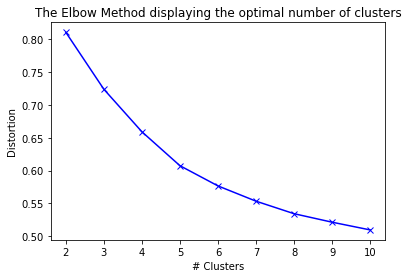

In [54]:
plt.plot(num_clusters_to_iter, distortions, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method displaying the optimal number of clusters')
plt.show()

In order to visualise these clusters, we will need to reduce the dimensionality of the original Dataframe so that we can represent each data point in a two dimensional space. This can be achieved by performing **Principal Component Analysis** on the data. This is done below.

In [ ]:
# Move PCA up here?

In [ ]:
#Choose more clusters
#The next most suitable combination of num_clusters/model is kmeans with 6 clusters
#Confirm this with elbow curve

kmeans = KMeans(n_clusters=6).fit(standard_train_array)
centroids = kmeans.cluster_centers_

# =============================================================

# 5. Principal Component Analysis

# =============================================================

There are eight parameters in this model so principal component analysis is performed below on the data before performing Spectral clustering.

#### Inspect dataframe which PCA is being performed on

In [ ]:
original_df.head()

#### Use PCA to project the data to 2 dimensions

In [ ]:
pca = PCA(n_components=2)

principal_components_array = pca.fit_transform(standard_train_array)

#### Look at how much variance these 2 axes explain

In [ ]:
pca.explained_variance_ratio_

#### Add these principal component columns to the rest of the data

In [ ]:
principal_df = pd.DataFrame(data = principal_components_array, columns = ['Principal_Component_1', 'Principal_Component_2'])
principal_df.head()

In [ ]:
final_df = pd.concat([full_df_nd_cluster, principal_df], axis = 1)

In [ ]:
final_df.head()

# =============================================================

# 6. Plot the clusters with the PCA axes

# =============================================================

## Plot the clusters

#### Choose the columns to plot

In [ ]:
pc1 = final_df['Principal_Component_1']
pc2 = final_df['Principal_Component_2']
group = final_df["group"]
cluster = final_df["Cluster"]

#### Visualise 2D projection

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Plotting the dataset accross the 2 principal components', fontsize = 20)

targets = ['young', 'old']
colors = ['b', 'y']

for target, color in zip(targets, colors):
    ax.scatter(pc1.loc[target == group], pc2.loc[target == group], c = color, s = 50)
    
ax.legend(targets)
ax.grid()

#### Plot the original data

In [ ]:
plt.scatter(pc1, pc2)

#### Plot the data colouring the different groups

In [ ]:
plt.scatter(pc1, pc2, c=np.where(0, 1, group=="young"), s=50)

#### Plot this data colouring the different clusters

In [ ]:
plt.scatter(pc1, pc2, c=cluster, s=50)

#### Plot this data with the clusters and their centroids

In [ ]:
plt.scatter(pc1, pc2, c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

# =============================================================

# 7. Analyse the clusters

# =============================================================

## See how the 'Old' and 'Young' fall into these clusters

In [ ]:
final_df.head()

#### Create a dataframe showing how many people people fell into each cluster

In [ ]:
all_cluster_df = pd.DataFrame(final_df[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "All"})

#### Change 'young' to 1 and 'old' to np.nan

In [ ]:
final_df["group"] = final_df["group"].replace('old', np.nan).replace('young', 1)

#### Create a dataframe showing how many young people fell into each cluster

In [ ]:
young_cluster_df = pd.DataFrame(final_df[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "Young"})

#### Create a dataframe showing how many old people fell into each cluster

In [ ]:
old_cluster_df = pd.DataFrame(final_df["group"].isnull().groupby(final_df["Cluster"]).sum().astype(int)).rename(columns={"group": "Old"})

#### Output how many 'young' and 'old' people fell into each cluster

In [ ]:
pd.merge(all_cluster_df, pd.merge(young_cluster_df, old_cluster_df, how="inner", on="Cluster"), how="inner", on="Cluster")